# Solving Equations with Grover's Algorithm

This experiments is inspired by QISKITs introduction of the Grover algorithm, which can be found at https://qiskit.org/textbook/ch-algorithms/grover.html. 

Grover algrithm is one of the most famous algorithms for Quantum Computers. It is often discussed as a kind of database search agorithm but this is, quite possibly a pretty bad misnomer. I do like to think of it as a solver for otherwise completely unstructured problems, i.e. problem where you have to brute force search the an entire solutions space of size $N$ for the best possible solution. Grover gives you a solution in $\sqrt{N}$ steps. For completeness sake: it does NOT speed up solutions exponentially (retaining polynomial speedup) and does thus not give an answer to the infamous $\mathbf{P=NP}$ conjecture.

We shall use it today to solve a simple mathematical problem, namely to find a solution to the problem $a+b=17$. This is, of course, NOT a completely unstructured problem and there are certainly MUCH quicker ways to solve the issue.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from numpy import pi
import numpy as np
import matplotlib.pylab as plt
sim = Aer.get_backend('aer_simulator') 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Classical Problems on a Quantum Computer

Since classical Physics is a subclass of Quantum Phyics it probably comes as no big surprise for you to finde, that any classical computation can be carried out on a Quantum Computer (and then some). If you want to port a classical computer programm into a Quantum circuit you could simply break down the classical software into its computational gates and you would find that there only NAND-gates on a classical computer.

<img src="NAND.png" width="25%"/>

All other gates and hence all possible claculation a classical computer can implement can be composed of series of NAND-gates. See https://de.wikipedia.org/wiki/NAND-Gatter for a list, if you are interested. The Quantum Equivalent of the NAND gates can be implemented with the so-called Toffoli-Gate. The action of the gate is defined as $\hat{TF}(|c_0\rangle{}|c_1\rangle{}|t\rangle{})= |c_0\rangle{}|c_1\rangle{}|t\oplus(c_0\cdot{}_1)\rangle{}$, hence it is the equivalent of the AND gate. It is defined is QISKIT:

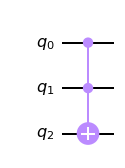

In [2]:
qc = QuantumCircuit(3)
qc.toffoli(0,1,2)
qc.draw()

The NAND gate can be implemented quite easily by simply negating the result

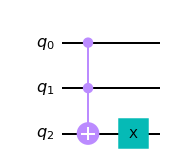

In [3]:
def NAND_gate(as_gate=True):
    qc = QuantumCircuit(3)
    qc.toffoli(0,1,2)
    qc.x(2)
    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "NAND"
        return U_s
    else:
        return qc

qc = NAND_gate(as_gate=False)
qc.draw()

We can use this function to create a truth-table and see that this is indeed equivalent to the gate:

In [4]:
def gate_test_onevalue(inp1, inp2, gate):
    qc = QuantumCircuit(3)
    if (inp1):
        qc.x(0)
    if (inp2):
        qc.x(1)       
    qc.append(gate,[0,1,2])

    qc.measure_all() 
    qc_t = transpile(qc, sim)
    results = sim.run(qc_t, shots=1).result().get_counts()
    for key, value in results.items():
        truth = int(key[0])
        break
    return truth
        
def gate_test(gate):
    r = [[0,0],[0,0]]
    for idx1, inp1 in enumerate([False, True]):
        for idx2, inp2 in enumerate([False, True]):
            r[idx1][idx2] = gate_test_onevalue(inp1, inp2, gate)
    return r

import pandas
def print_truth_table(gate):
    t = gate_test(gate)
    print(pandas.DataFrame(t, [0, 1], [0, 1]))


Which we apply into the NAND-gate:

In [5]:
print('NAND-gate') 
print_truth_table(NAND_gate(False))

NAND-gate
   0  1
0  1  1
1  1  0


We can equivalently define and Test shortcuts for ANDs and ORs, which will come in handy, later on. To create the OR and we use the fact that $A\ \mathrm{or}\ B = \mathrm{not}(\mathrm{not}(A\ \mathrm{or}\ B)) = \mathrm{not}(\mathrm{not}(A)\ \mathrm{and}\ \mathrm{not}(B))$. The XOR-gate is constructed from two CNOTs.

In [6]:
def OR_gate(as_gate=True):
    qc = QuantumCircuit(3)
    qc.x(0)
    qc.x(1)
    qc.toffoli(0,1,2)
    qc.x(2)
    qc.x(0)
    qc.x(1)
    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "OR"
        return U_s
    else:
        return qc

def AND_gate(as_gate=True):
    qc = QuantumCircuit(3)
    qc.toffoli(0,1,2)
    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "AND"
        return U_s
    else:
        return qc

def XOR_gate(as_gate=True):
    qc = QuantumCircuit(3)
    qc.cx(0,2)
    qc.cx(1,2)
    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "XOR"
        return U_s
    else:
        return qc

print('OR Gate')
print_truth_table(OR_gate())
print('')
print('AND Gate')
print_truth_table(AND_gate())
print('')
print('XOR Gate')
print_truth_table(XOR_gate())

OR Gate
   0  1
0  0  1
1  1  1

AND Gate
   0  1
0  0  0
1  0  1

XOR Gate
   0  1
0  0  1
1  1  0


As NAND implements a complete basis set for classic computers, we therefore conclude that we can use to cast any classical algorithm in a quantum form. What does this mean? This means that the algorithm behaves exactly like the classical one, if we run it with CBS as an input (where the CBS are supposed to be read like binary numbers for the classical input). However, we can also run the algorithm with an entangled superposition state and retain a true quantum result. As a example we take an entirely fictitious algorithm that is fed with a four bit number. We run it twice, once with the input number “12” and once with the input “6”. Suppose the algorithm us VERY hard to compute, then we would, after a long wait compile the following table:
<table>
    <tr>
        <th>
            Input
        </th>
        <td>
            1100 (12)
        </td>
        <td>
            0110 (6)
        </td>
    </tr>
    <tr>
        <th>
            Output
        </th>
        <td>
            1110 (14)
        </td>
        <td>
            0011 (3)
        </td>
    </tr>
</table>
We can now turn the algorithm into a quantum version by replacing all its NANDs with their quantum equivalents and we would be guaranteed to get:
<table>
    <tr>
        <th>
            Input
        </th>
        <td>
            $|1100\rangle\ (12)$ 
        </td>
        <td>
            $|0110\rangle\ (6)$
        </td>
    </tr>
    <tr>
        <th>
            Output
        </th>
        <td>
            $|1110\rangle\ (14)$
        </td>
        <td>
            $|0011\rangle\ (3)$
        </td>
    </tr>
</table>
This is certainly not an improvement. However, because the quantum algorithm is necessarily linear (it is a unitary matrix!) this means that if we input a superposition of CBS-states we obtain a result, which is superimposed of both classical runs:
<table>
    <tr>
        <th>
            Input
        </th>
        <td>
            $\alpha|1100\rangle+\beta|0110\rangle$
        </td>
    </tr>
    <tr>
        <th>
            Output
        </th>
        <td>
            $\alpha|1110\rangle+\beta|0011\rangle$
        </td>
    </tr>
</table>
Of course, we can generalize this to all possible superpositions, if we wanted to. We are now in a position, where we can run a classical algorithm with all possible classical inputs at once! This is, however, not really useful, because upon a simple measurement in the CBS we would still collapse onto ONE particular solution of the algorithm and we would not even know which one. So, we can only get a real advantage out of this, if what we are really looking for are specific properties of groups of solutions.

### Task 1: Addition as an Example
We shall implement a circuit for the addition of two n-bit numbers $a$ and $b$ in a quantum circuit. Bitwise addion is carried out in the same way as you would add number son paper, i.e. add digits from the least to the most significant and using carry-bits. The circuit is depicted in the following chart:

<center><img src="FullAdder.png" width="25%"/></center>

The circuit must be applied from the $0^{th}$ bit to the $n-1^{st}$ bit, starting without a carry input quibt and using the $c_{out}$ as $c_{in}$ for the next Qubit. The last $c_{out}$ is retained. The result thus has $n+1$ Qubits, namely $(s_0,...,s_{n+1}, c_{out})$.

Implement a 4 bit Quantum-Adder and demonstrate that $13+6=19$.

We start with creating the half-adder:

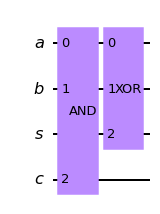

In [7]:
def half_adder(as_gate=True):
    a_qubit = QuantumRegister(1, name='a')
    b_qubit = QuantumRegister(1, name='b')
    s_qubit = QuantumRegister(1, name='s')
    c_qubit = QuantumRegister(1, name='c')
    qc = QuantumCircuit(a_qubit, b_qubit, s_qubit, c_qubit)

    qc.append(AND_gate(), [a_qubit,b_qubit,c_qubit])
    qc.append(XOR_gate(), [a_qubit,b_qubit,s_qubit])
   

    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "HalfAdd"
        return U_s
    else:
        return qc

half_adder(as_gate=False).draw()

We then create the full Adder from the Half Adder. This requires intermediate QuBits to store intermediate results (altogether three), corresponding to any of the lines not connected to input or output in the image above. We call these "auxiliary" qubits.

We want to be able to reuse then, so we have to clean up (uncompute) them after usage. This is done after the or-gate. Uncomputing aux1, and aux2 is simple. We can just repeat the first line; where aux1 and aux2 are the output. Any bit-flip carried out on them will be undone by a second flip. If no flip was carried out a second no-flip will not do anthing either. However, can't do this as a first step in uncomputation because we also need to uncompute aux3 for which we need the intermediary result from aux2. We can use the same approach here (uncomputation through recomputation) but can't just invoke the half-adder again, because that would uncompute s_qubit as well. Thus we just enact the part of the half-adder again. This is a bit unelegant but I don't have time for a smoother solution.

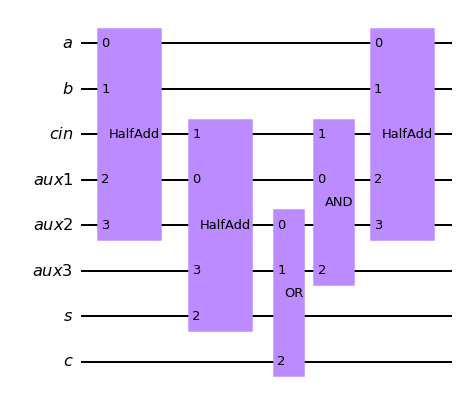

In [8]:
def full_adder(as_gate=True):
    a_qubit = QuantumRegister(1, name='a')
    b_qubit = QuantumRegister(1, name='b')
    cin_qubit = QuantumRegister(1, name='cin')
    aux1_qubit = QuantumRegister(1, name='aux1')
    aux2_qubit = QuantumRegister(1, name='aux2')
    aux3_qubit = QuantumRegister(1, name='aux3')
    s_qubit = QuantumRegister(1, name='s')
    c_qubit = QuantumRegister(1, name='c')
    qc = QuantumCircuit(a_qubit, b_qubit, cin_qubit, aux1_qubit, aux2_qubit, aux3_qubit, s_qubit, c_qubit)

    #Compute Sum
    qc.append(half_adder(), [a_qubit, b_qubit, aux1_qubit, aux2_qubit])
    qc.append(half_adder(), [aux1_qubit, cin_qubit, s_qubit, aux3_qubit])
    qc.append(OR_gate(), [aux2_qubit, aux3_qubit, c_qubit])
    #Uncompute aux1-3
    qc.append(AND_gate(), [aux1_qubit, cin_qubit, aux3_qubit])
    qc.append(half_adder(), [a_qubit, b_qubit, aux1_qubit, aux2_qubit])
   

    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "FullAdd"
        return U_s
    else:
        return qc

full_adder(as_gate=False).draw()

We then compose the addition circuit by stacking the full adder

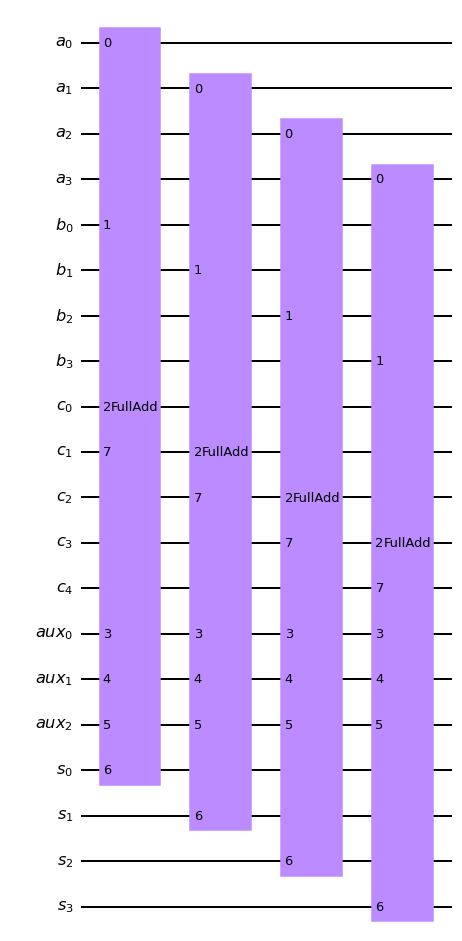

In [9]:
def nbit_addition(nbits, as_gate=True):
    a_qubits = QuantumRegister(nbits, name='a')
    b_qubits = QuantumRegister(nbits, name='b')
    c_qubits = QuantumRegister(nbits+1, name='c')
    aux_qubits = QuantumRegister(3, name='aux')
    s_qubits = QuantumRegister(nbits, name='s')
    qc = QuantumCircuit(a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits)
    
    for k in range(nbits):
        qc.append(full_adder(), [a_qubits[k], b_qubits[k], c_qubits[k], aux_qubits[0], aux_qubits[1], aux_qubits[2], s_qubits[k], c_qubits[k+1]])
 

    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "Addition"
        return U_s
    else:
        return qc

nbit_addition(4,as_gate=False).draw()

Let's now calculate 13 (1101) + 6 (0110) = 19 (1 0011)

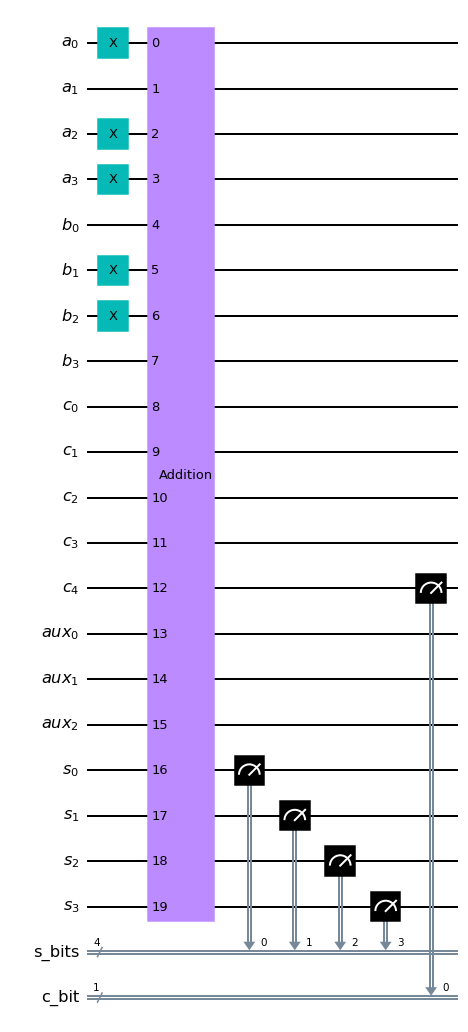

In [10]:
nbits = 4;
a_qubits = QuantumRegister(nbits, name='a')
b_qubits = QuantumRegister(nbits, name='b')
c_qubits = QuantumRegister(nbits+1, name='c')
aux_qubits = QuantumRegister(3, name='aux')
s_qubits = QuantumRegister(nbits, name='s')

s_bits = ClassicalRegister(nbits, name='s_bits')
c_bit = ClassicalRegister(1, name='c_bit')


qc = QuantumCircuit(a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits, s_bits, c_bit)

#initiate the 13 (reverse order!)
qc.x(a_qubits[3])
qc.x(a_qubits[2])
qc.x(a_qubits[0])

#initiate the 6 (reverse order!)
qc.x(b_qubits[2])
qc.x(b_qubits[1])


#this seems like a rather unelegant way to compile the list of qubits but it's the inly way I found that would work
qlist = []
for qubit in a_qubits:
    qlist.append(qubit)
for qubit in b_qubits:
    qlist.append(qubit)
for qubit in c_qubits:
    qlist.append(qubit)
for qubit in aux_qubits:
    qlist.append(qubit)
for qubit in s_qubits:
    qlist.append(qubit)
qc.append(nbit_addition(4), qlist)
#this seems like the more eleqgant solution but does not work
#qc.append(nbit_addition(4), [a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits])


qc.measure(s_qubits, s_bits)
qc.measure(c_qubits[nbits], c_bit)

qc.draw()


Let's try this out

{19: 1}


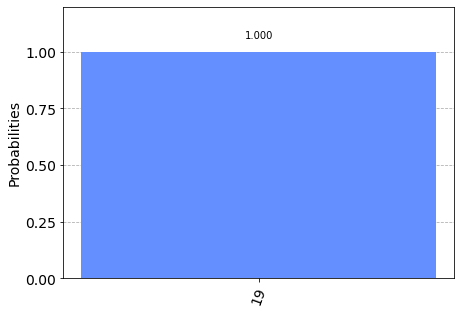

In [11]:
qc_t = transpile(qc, sim)
result = sim.run(qc_t, shots=1).result()
cts = result.get_counts().int_outcomes()
print(cts)
plot_histogram(cts)

This gives 19, as expected. Feel free to play around with it.

### Task 2: Uncomputation
The algorithm as such will probably need ancilla Qubits to store intermediate results. The carry lowest $n-1$ carry bits are such an example. For usage of the algorithm as an Oracle (see below) we MUST MAKE SURE that all ancillas are returned to their origina state, because otherwise the entire mathematics of the algorithms does not work anymore (it gets mixed up in entanglement, if you so wish). This process is called uncomputation.

Implement a 4 bit Quantum-Adder and demonstrate that $13+6=19$ which is fully uncomputed, e.g. it does not change the input qubits and also does not change the ancillas. Only changing of result QuBits is permissible.

We have already cleaned up the ancilla bits of the Full-Adder. We only need to clean up the lower n carry bits (the upper one is a part of the result). We thus redefine the nbit_addition function. We use the test approach of uncomputation by recomputation. To do so, we need to split off the Carry-Calculation-Part of the Full Adder, becuase we only need to uncompute this part. Also keep in mind that we have to do the uncomputation backwards, because we need the n-1-th carry but to calc the nth.

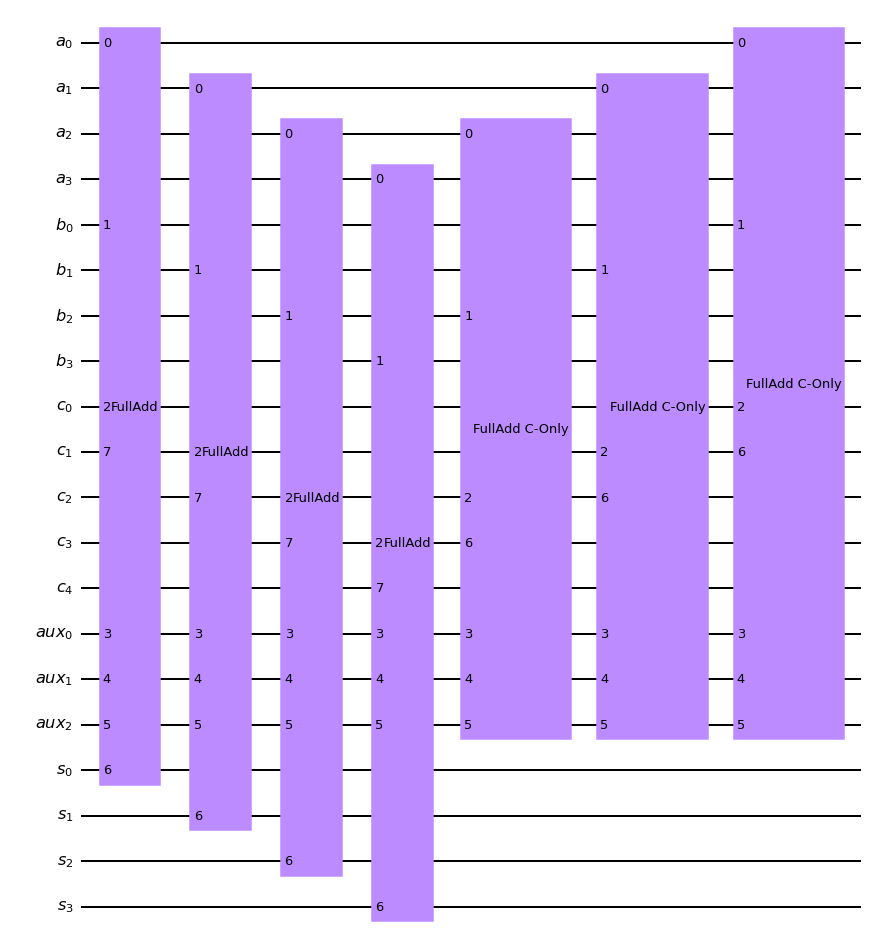

In [12]:
def full_adder_c_only(as_gate=True):
    a_qubit = QuantumRegister(1, name='a')
    b_qubit = QuantumRegister(1, name='b')
    cin_qubit = QuantumRegister(1, name='cin')
    aux1_qubit = QuantumRegister(1, name='aux1')
    aux2_qubit = QuantumRegister(1, name='aux2')
    aux3_qubit = QuantumRegister(1, name='aux3')
    c_qubit = QuantumRegister(1, name='c')
    qc = QuantumCircuit(a_qubit, b_qubit, cin_qubit, aux1_qubit, aux2_qubit, aux3_qubit, c_qubit)

    #Compute Sum
    qc.append(half_adder(), [a_qubit, b_qubit, aux1_qubit, aux2_qubit])
    qc.append(AND_gate(), [aux1_qubit, cin_qubit, aux3_qubit])
    qc.append(OR_gate(), [aux2_qubit, aux3_qubit, c_qubit])
    #Uncompute aux1-3
    qc.append(AND_gate(), [aux1_qubit, cin_qubit, aux3_qubit])
    qc.append(half_adder(), [a_qubit, b_qubit, aux1_qubit, aux2_qubit])
   

    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "FullAdd C-Only"
        return U_s
    else:
        return qc
    
def nbit_addition_clean(nbits, as_gate=True):
    a_qubits = QuantumRegister(nbits, name='a')
    b_qubits = QuantumRegister(nbits, name='b')
    c_qubits = QuantumRegister(nbits+1, name='c')
    aux_qubits = QuantumRegister(3, name='aux')
    s_qubits = QuantumRegister(nbits, name='s')
    qc = QuantumCircuit(a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits)
    
    for k in range(nbits):
        qc.append(full_adder(), [a_qubits[k], b_qubits[k], c_qubits[k], aux_qubits[0], aux_qubits[1], aux_qubits[2], s_qubits[k], c_qubits[k+1]])
    for k in range(nbits-2,-1,-1):
        qc.append(full_adder_c_only(), [a_qubits[k], b_qubits[k], c_qubits[k], aux_qubits[0], aux_qubits[1], aux_qubits[2], c_qubits[k+1]])

    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "Addition Clean"
        return U_s
    else:
        return qc

nbit_addition_clean(4,as_gate=False).draw()

Let's see: we try this out but now we measure all the qubits, because we want to see that the aux's are all zero.

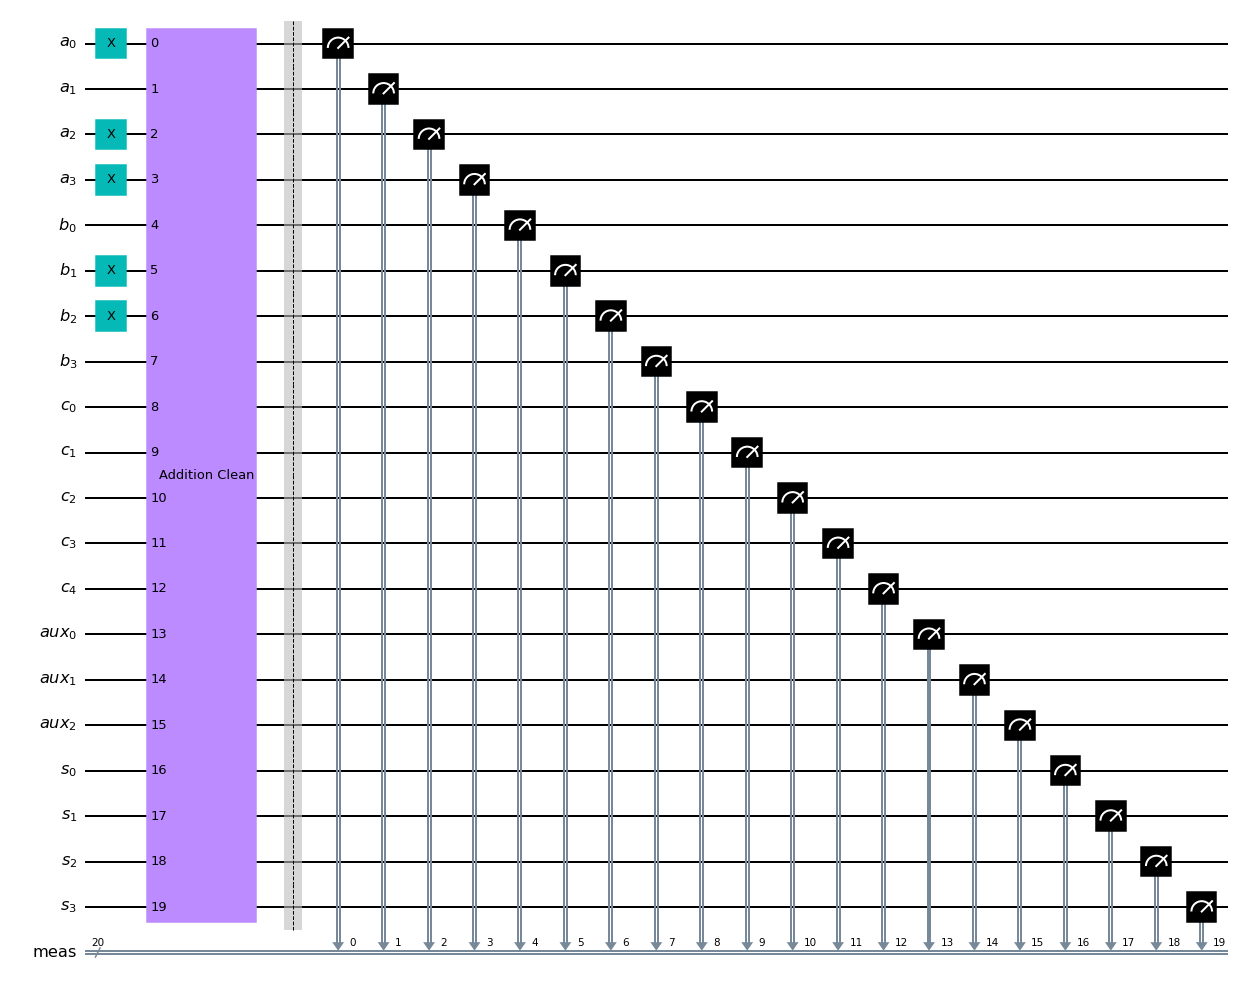

In [13]:
nbits = 4;
a_qubits = QuantumRegister(nbits, name='a')
b_qubits = QuantumRegister(nbits, name='b')
c_qubits = QuantumRegister(nbits+1, name='c')
aux_qubits = QuantumRegister(3, name='aux')
s_qubits = QuantumRegister(nbits, name='s')



qc = QuantumCircuit(a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits)

#initiate the 13 (reverse order!)
qc.x(a_qubits[3])
qc.x(a_qubits[2])
qc.x(a_qubits[0])

#initiate the 6 (reverse order!)
qc.x(b_qubits[2])
qc.x(b_qubits[1])


#this seems like a rather unelegant way to compile the list of qubits but it's the inly way I found that would work
qlist = []
for qubit in a_qubits:
    qlist.append(qubit)
for qubit in b_qubits:
    qlist.append(qubit)
for qubit in c_qubits:
    qlist.append(qubit)
for qubit in aux_qubits:
    qlist.append(qubit)
for qubit in s_qubits:
    qlist.append(qubit)
qc.append(nbit_addition_clean(4), qlist)
#this seems like the more eleqgant solution but does not work
#qc.append(nbit_addition(4), [a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits])


qc.measure_all()

qc.draw()

Let's go.

{'00110001000001101101': 1}


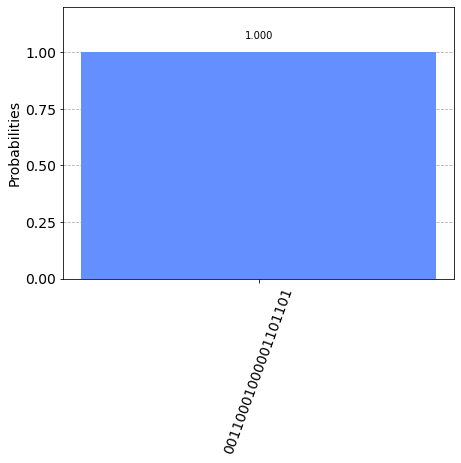

In [14]:
qc_t = transpile(qc, sim)
result = sim.run(qc_t, shots=1).result()
cts = result.get_counts()
print(cts)
plot_histogram(cts)

This has worked. All results are fine, all low carry bit and aux bits are uncomputed. Congratulations, you can now compute a+b on a Quantum Computer.

## Quantum Oracles

For many computationally hard to solve problems, the best solution is systematically test possible solution candidates until a proper solution is found. This approach is said to use and “oracle” function: a function $O(x)$, which returns $O(x)=0$ for all $x$, which are not solutions to the problem and $O(x)=1$ for proper solutions to the problem. The name “oracle” is altogether fitting because it contains two central ideas to this solution approach
- the answer is always correct but in the most cases of very minimal use, and
- one it usually assumes that asking the oracle is connected to some cost.

The difference of the 21st century and the 2nd century BC is that this cost is due in computational resources and not in sacrificial goats.

<center><img src="goat.jpg" width="25%"/></center>

Using our understanding of Classical Problems on a Quantum Computer we can, of course, create a quantum version of the oracle $\hat{O}$, i.e., $\hat{O}|x\rangle|o\rangle=|x\rangle|o\oplus{}O(x)\rangle$, where $|x\rangle$ is the register of input Qubits and $|o\rangle$ is the single output qubit, i.e. the Orcacle's answer.

It is helpful to initialize the output Qubit into a superposition state $|q\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ because this implies that

$$\hat{O}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)=(-1)^{o(x)}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$$.

Which is a rather funny result, because it tells us that the result qubit $|o\rangle$ does not change its state irrespective of the input being a solution. The quantum oracle rather marks solutions to search problems by shifting their phase by $\pi$ with respect to all other solutions. You can also think in eigenstates: all possible CBS inputs are eigenstates to the Oracle operator (if $|o\rangle$ is chosen appropriately) with the eigentvalue being +1 or -1 depending on the correctness of the result. Because the application of the oracle does not affect the oracle QuBit at all, it shall be omitted from the fruther discussion.

## The Grover Algorithm
The Grover Aogorithm uses the markdown-property imposed by the Oracle operator to amplify the quantum aplitude of correct solutions. It does so by the application of the Grover-Operator $\hat{G}=(2|\overline{\psi}\rangle\langle\overline{\psi}|-\hat{I})$, where $|\overline{\psi}\rangle=\sum_x|x\rangle$ is the balaned superposition of all possible CBS-states (the average).

The implementation of the Grover-Algorithm is discussed in detail in the QISKIT book and we give it here for reference.

In [15]:
def grover_operator(nqubits, as_gate=True):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "G"
        return U_s
    else:
        return qc

This is what the circuit looks like:

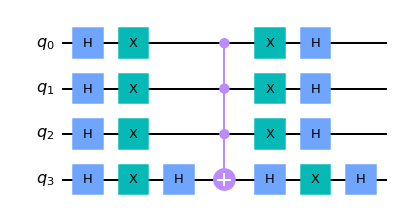

In [16]:
grover_operator(4, as_gate=False).draw()

Use the grover_operator function in such as way:

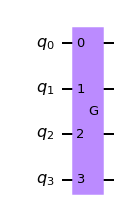

In [17]:
qc = QuantumCircuit(4)
qc.append(grover_operator(4), [0,1,2,3])
qc.draw()

## The Grover Algorithm

The entire algrithm works in the following way:

Initialization:
1. Initiate the input  $|x\rangle$ in a balanced superposition using $\hat{H}$-gates on all QuBits
2. Initiate the Oracle $|o\rangle$  into the state $o\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$.

Iteration:
1. Apply the Oracle Operator $\hat{O}$.
2. Apply the grover-Operator $\hat{g}$.
3. Repeat Steps 1+2 for $\frac{\pi}{4}\sqrt{\frac{N}{M}}$ times, where $N=2^n$ is the size of the search space and $M$ is the number of correct answers.*

$*$There is an efficient way of determining $M$ if it is unknown, called *Quantum Counting*.

Why does the algorithm work? To answer that question it is useful to imagine the entire search space spanned by all as a high-dimensional vector space. This space is spanned by two linearily independent subspaces, the $M$-dimensional subspace of “correct” answers $|x'\rangle$ and the $N-M$ dimensional subspace or incorrect answers $|x''\rangle$. Within both of these subspaces we define normalized superposition states:

$$ |\alpha\rangle = \frac{1}{\sqrt{N-M}}\sum_{x''}|x''\rangle$$
$$ |\beta\rangle = \frac{1}{\sqrt{M}}\sum_{x'}|x'\rangle$$

The initial state of the input register produced by an equal superposition of all CBS is then simply:

$$|\psi\rangle=\sqrt{\frac{N-M}{N}}|\alpha\rangle+\sqrt{\frac{M}{N}}|\beta\rangle=\cos{\frac{\theta_0}{2}}|\alpha\rangle+\sin{\frac{\theta_0}{2}}|\beta\rangle$$

where $\theta_0\ll1$ because there are many more wrong solutions than there are correct solutions. We find that the angle $\theta$ is a measure of the “correctness”, e.g. $\theta=0$ is a balanced superposition of all wrong results, whereas $\theta=\pi$ is a superposition of all correct answers. The Grover-Algorithm starts with $\theta=\theta_0$ and increases the angle for every iteration. It is also noteworthy that $|\psi(\theta_0)\rangle=|\overline{x}\rangle$, i.e. the starting point of the algorithm is the average.

The first step in the iteratation is the application of the Oracle and we had seen that the oracle flips the sign of the correct answers hence:
$$\hat{O}|\psi(\theta)\rangle=\cos{\frac{\theta}{2}}|\alpha\rangle-\sin{\frac{\theta}{2}}|\beta\rangle=|\psi(-\theta)\rangle$$

If visualized in the $|\alpha\rangle-|\beta\rangle$-plane this amount to a reflecton at the $|\alpha\rangle$-axis.

The application of the Grover operator $\hat{G}=(2|\psi(\theta_0)\rangle\langle\psi(\theta_0)|-\hat{I})$ changes the value to:

$$\hat{G}|\psi(-\theta)\rangle=\cos{\frac{2\theta_0+\theta}{2}}|\alpha\rangle+\sin{\frac{2\theta_0+\theta}{2}}|\beta\rangle=|\psi(2\theta_0+\theta)\rangle$$

This is because the Grover operator also does a reflection but this time about the initial state.

Since we have started in the point $\theta_0$ we find that after $k$ iterations we are in the state:

$$(\hat{G}\hat{O})^k|\psi(\theta_0)\rangle=|\psi(\frac{2k+1}{2}\theta_0)\rangle$$

The geometric interpretation is indeed quite simple. The application of $\hat{G}$ has the state $|\psi\left(\theta\right)\rangle$ by $2\theta_0$ counterclockwise from the $|\alpha\rangle$ towards the $|\beta\rangle$ direction and has thus increased the relative quantum amplitude and therefore the likelihood of observing a correct answer.

<center><img src="Grover-Rotation.png" width="30%"/></center>

It is now a mere question of when to terminate, such that we do not “overrotate” and again decrease the likelihood of the system being in any of the CBS, which comprise $|\beta\rangle$. Quantitatively we must terminate the algorithm, when $\frac{2k+1}{2}\theta_0=\frac{\pi}{2}$ this means that: $k=\frac{\pi}{2\theta}-\frac{1}{2}$.

Let’s assume for simplicity that $M\ll N$, e.g. that a correct answer is a fairly rare event. Note that this approximation is an exclusively technical approximation. We can approximate $\theta\approx 2\sqrt{M/N}$ and thus we get:

$$K=\frac{\pi}{4}\left(\frac{N}{M}\right)^{1/2}-\frac{1}{2}\approx\frac{\pi}{4}\left(\frac{N}{M}\right)^{1/2}$$



### Task 3: Grover Solution finding 
Use the grover algorithm and your 4-bit Adding-Circuit to find a solution to the problem $a+b=17$.

We start by calculating the number of iteration we need to find a solution. We do so by cheating, as we, of course, know the solutions beforehand. There are $M=14$ solutions, namely $2+15$, $3+14$, ... , $15+2$. The total search space is $N=2^{8}=256$. We hance find that $K=\frac{\pi}{4}\left(\frac{N}{M}\right)^{1/2}=3.2$, so we need roughly $K\approx3$ iterations of the circuit. That was easy.

Next we need to design the oracle. Let's first assume that we have the Addition carried out such that we have the (quantum superposition) of results stored in register $(s_0,...,s_{n+1}, c_{out})$. We must compare bitwise with 17=10001, e.g. the result is ONLY 17 if all the number are equal. To do so we employ an $n+1$ input Toffoli-Gate, which is a natural AND (e.g. it operates if all input are 1) together with $NOT$-gates at those bts, which are supposed to be $0$. Don't forget to uncompute those!

In [18]:
def comparator_17(as_gate=True):
    qc = QuantumCircuit(6)
    ##prepare for comparison with 10001 by flipping the middle three bits
    qc.x(1)
    qc.x(2)
    qc.x(3)
    ##compare and store result in qubit 6
    qc.mct(list(range(5)), 5)  # multi-controlled-toffoli
    ##unflip 
    qc.x(1)
    qc.x(2)
    qc.x(3)
    
    
    if (as_gate):
        U_s = qc.to_gate()
        U_s.name = "Compare with 17"
        return U_s
    else:
        return qc

This is what the circuit looks like

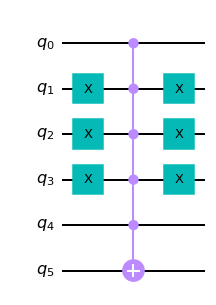

In [19]:
comparator_17(as_gate=False).draw()

Use it in such a way

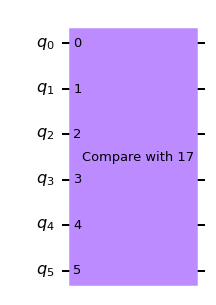

In [20]:
qc = QuantumCircuit(6)
qc.append(comparator_17(), [0,1,2,3,4,5])
qc.draw()

The we need to initialize everything properly. Keep in mind that we have to initialize both the input qubits and the oracle qubits and we have to create empty ancilliaries.

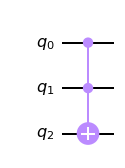

In [21]:
qc = QuantumCircuit(3)
qc.toffoli(0,1,2)
qc.draw()

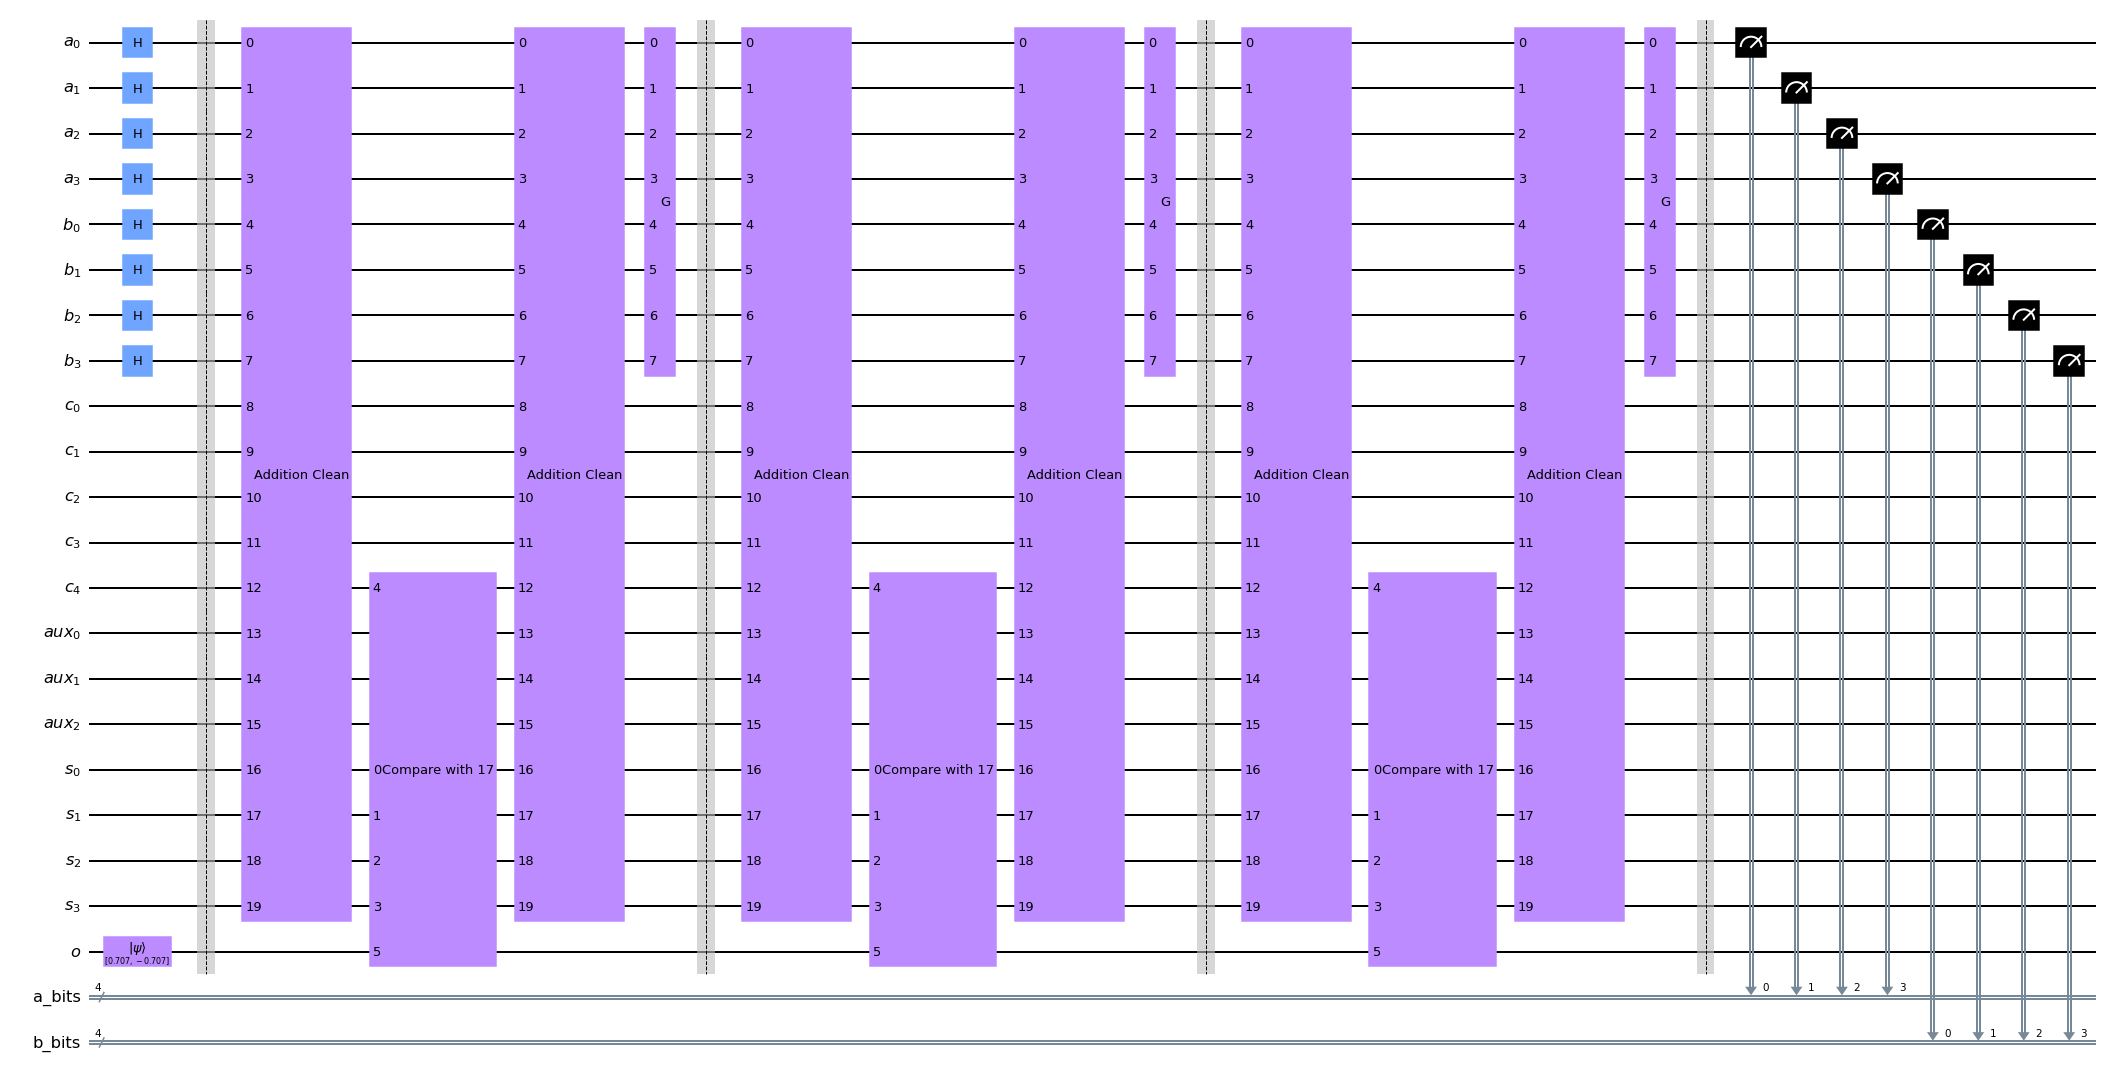

In [23]:
#create all Qubits, this time with names
a_qubits = QuantumRegister(4, name='a')
b_qubits = QuantumRegister(4, name='b')
c_qubit = QuantumRegister(5, name='c')
aux_qubits = QuantumRegister(3, name='aux')
s_qubits = QuantumRegister(4, name='s')
o_qubit = QuantumRegister(1, name='o')
a_bits = ClassicalRegister(4, name='a_bits')
b_bits = ClassicalRegister(4, name='b_bits')

qc = QuantumCircuit(a_qubits, b_qubits, c_qubits, aux_qubits, s_qubits, o_qubit, a_bits, b_bits)

#Initialize into to balanced superposition
qc.h(a_qubits)
qc.h(b_qubits)

#Initialize Oracle Qubit onto Linear Down Polarization (could also use H->RZ->RZ)
qc.initialize([1, -1]/np.sqrt(2), o_qubit)

qlist = []
for qubit in a_qubits:
    qlist.append(qubit)
for qubit in b_qubits:
    qlist.append(qubit)
for qubit in c_qubits:
    qlist.append(qubit)
for qubit in aux_qubits:
    qlist.append(qubit)
for qubit in s_qubits:
    qlist.append(qubit)
    
qlist2 = []
for qubit in s_qubits:
    qlist2.append(qubit)
qlist2.append(c_qubit[4])
qlist2.append(o_qubit)

qlist3 = []
for qubit in a_qubits:
    qlist3.append(qubit)
for qubit in b_qubits:
    qlist3.append(qubit)

#first grover iteration
qc.barrier()
qc.append(nbit_addition_clean(4), qlist)
qc.append(comparator_17(),qlist2) 
qc.append(nbit_addition_clean(4), qlist)
qc.append(grover_operator(8), qlist3)


#second grover iteration
qc.barrier()
qc.append(nbit_addition_clean(4), qlist)
qc.append(comparator_17(),qlist2) 
qc.append(nbit_addition_clean(4), qlist)
qc.append(grover_operator(8), qlist3)


#third grover iteration
qc.barrier()
qc.append(nbit_addition_clean(4), qlist)
qc.append(comparator_17(),qlist2) 
qc.append(nbit_addition_clean(4), qlist)
qc.append(grover_operator(8), qlist3)


#that's it, we are ready to measure a and b
qc.barrier()
qc.measure(a_qubits, a_bits)
qc.measure(b_qubits, b_bits)

qc.draw(fold=-1)

Now we run the code 100 times to see the results distribution. Keep the fingers crossed.

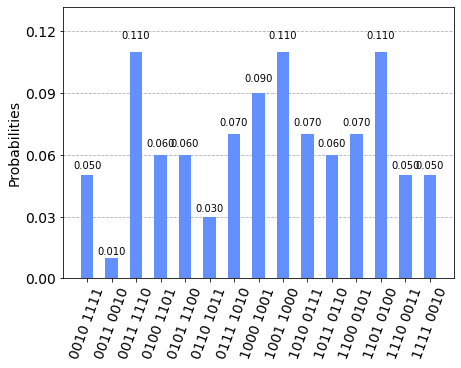

In [26]:
qc_t = transpile(qc, sim)
result = sim.run(qc_t, shots=100).result()
cts = result.get_counts()
plot_histogram(cts)

The results are all combinations of a and b that produce 17. You can verify by taking the first block of 4 bits and add them with the seocnd block of 4 qubits. Example from the first 0010 (2) + 1111 (15) = 17.

The same is true for all results (at least to should be true for most, because we enver end up perfetly at $|\beta\rangle$. But, and this is important: <b> with just three steps we (rbute force) find a solution in a serach space with 256 possible items. </b>. This is amazing.